# Time series of temperature gradient

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

datapath1 = '../Processed_data/Nino3_monthly/'
datapath2 = '../Processed_data/WP_monthly/'
experiments = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
          'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']

# create dictionary of data for each model, containing only the member we want to use:
data_dict1 = {}; data_dict2 = {};
for model in models:
    data_dict1[model] = {}; data_dict2[model] = {};
    
    file1 = datapath1 + model + '_nino3_monthlyindex.txt'
    file2 = datapath2 + model + '_wp_monthlyindex.txt'
    data_table1 = pd.read_csv(file1, index_col=0, header=[0,1], keep_default_na = False)
    data_table2 = pd.read_csv(file2, index_col=0, header=[0,1], keep_default_na = False)
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM']:
        for exp in experiments:
            member = 'r1i1p1f1'
            data_list1 = data_table1[exp][member].values;
            data_dict1[model][exp] = np.array([np.float(i) for i in data_list1 if i])
            data_list2 = data_table2[exp][member].values;
            data_dict2[model][exp] = np.array([np.float(i) for i in data_list2 if i])
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        for exp in experiments:
            if exp == 'piControl' and model == 'MCM-UA-1-0':
                member = 'r1i1p1f1'
            else:
                member = 'r1i1p1f2' # I have checked that historical f2 branches from piControl f1 in MCM-UA-1-0.
            if exp in data_table1: # additional if-test here, since 'MCM-UA-1-0' is missing the 'ssp126' experiment
                data_list1 = data_table1[exp][member].values
                data_dict1[model][exp] = np.array([np.float(i) for i in data_list1 if i]) 
                data_list2 = data_table2[exp][member].values
                data_dict2[model][exp] = np.array([np.float(i) for i in data_list2 if i])   
    elif model in ['CNRM-ESM2-1']:
        for exp in experiments:
            if exp == 'piControl':
                member = 'r1i1p1f2'
            else: 
                member = 'r2i1p1f2' # I have checked that historical r2 branches from piControl r1.
            data_list1 = data_table1[exp][member].values
            data_dict1[model][exp] = np.array([np.float(i) for i in data_list1 if i])  
            data_list2 = data_table2[exp][member].values
            data_dict2[model][exp] = np.array([np.float(i) for i in data_list2 if i])

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Define anomalies as deviations from piControl climatology

In [2]:
ssp_length = 86*12-1; # cut in year 2100. Some exp go beyond this year.

anomalies1 = {}; anomalies2 = {}

for model in models:
    anomalies1[model] = {}; anomalies2[model] = {}
    exp = 'piControl'
    control_data1 = data_dict1[model][exp]; control_data2 = data_dict2[model][exp]
    # then find piControl climatology:
    c_anom1 = np.concatenate(([np.nan],control_data1,[np.nan]))
    c_anom2 = np.concatenate(([np.nan],control_data2,[np.nan]))
    clim1 = np.zeros(12); clim2 = np.zeros(12);
    for month in range(12):
        clim1[month] = np.nanmean(c_anom1[month::12])
        clim2[month] = np.nanmean(c_anom2[month::12])
    
    anomalies1[model][exp] = control_data1 - np.tile(clim1,int(len(c_anom1)/12))[1:-1]
    anomalies2[model][exp] = control_data2 - np.tile(clim2,int(len(c_anom2)/12))[1:-1]
    
    for exp in experiments[2:]:
        if exp in data_dict1[model]:
            hist_data1 = data_dict1[model]['historical']; hist_data2 = data_dict2[model]['historical'];
            ssp_data1 = data_dict1[model][exp][:ssp_length]; ssp_data2 = data_dict2[model][exp][:ssp_length]
            # approximate missing end of historical by a mean
            exp_data1 = np.concatenate((hist_data1, [np.mean([hist_data1[-1], ssp_data1[0]])], ssp_data1))
            exp_data2 = np.concatenate((hist_data2, [np.mean([hist_data2[-1], ssp_data2[0]])], ssp_data2))
            
            anomalies1[model][exp] = exp_data1 - np.tile(clim1,165+86)[1:-1]
            anomalies2[model][exp] = exp_data2 - np.tile(clim2,165+86)[1:-1]
    

## Compute temprature gradient as difference between anomalies in the nino3 region and the warm pool

In [5]:
gradient = {}
for model in models:
    gradient[model] = {}
    for exp in ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']:
        if exp in anomalies1[model]:
            gradient[model][exp] = anomalies1[model][exp] - anomalies2[model][exp]

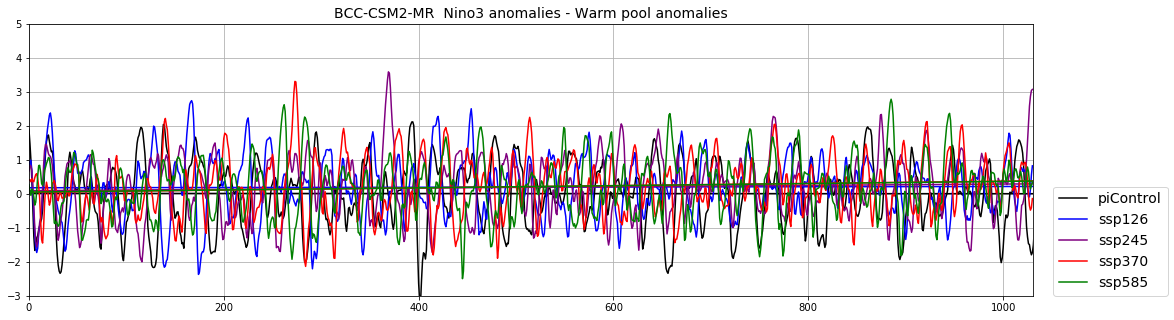

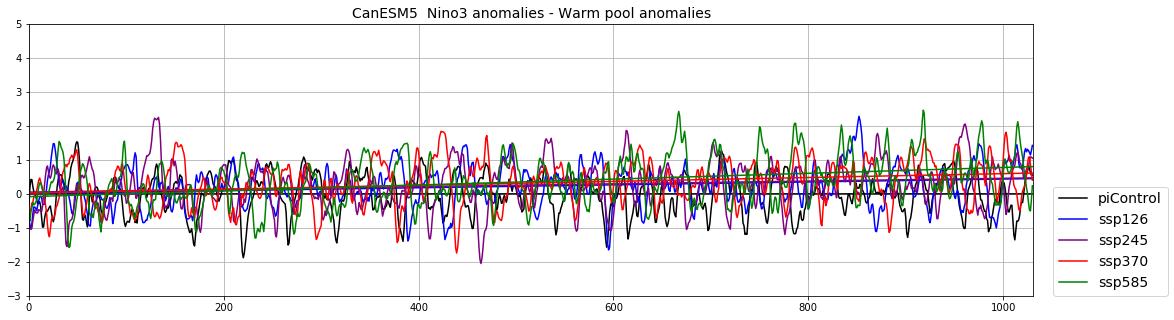

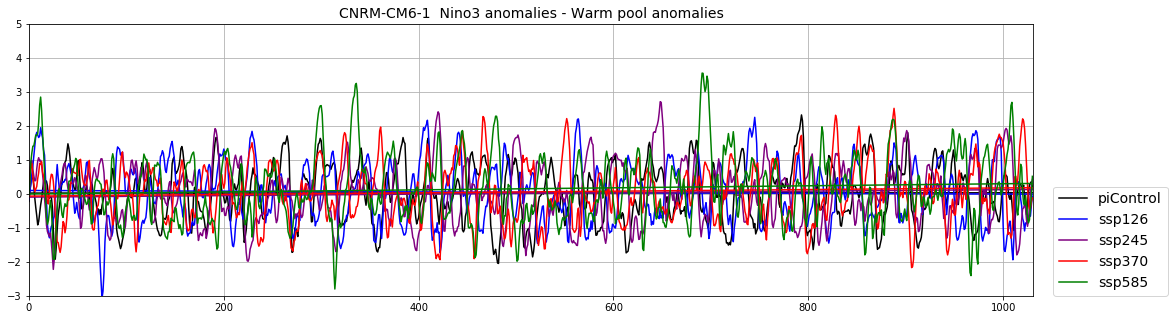

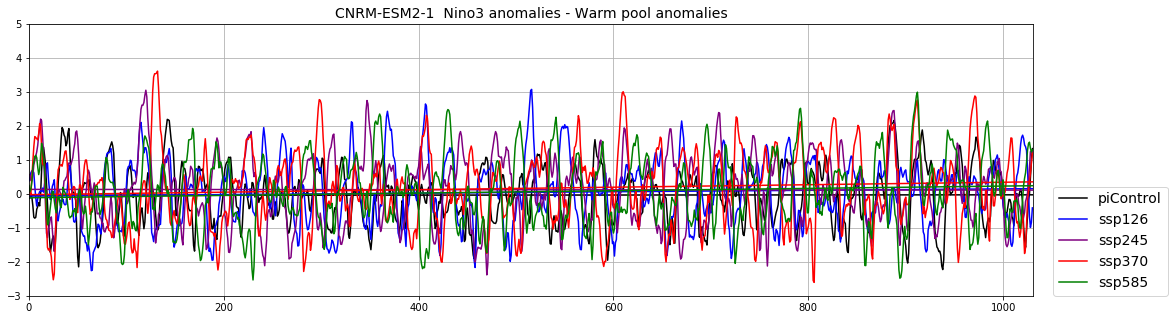

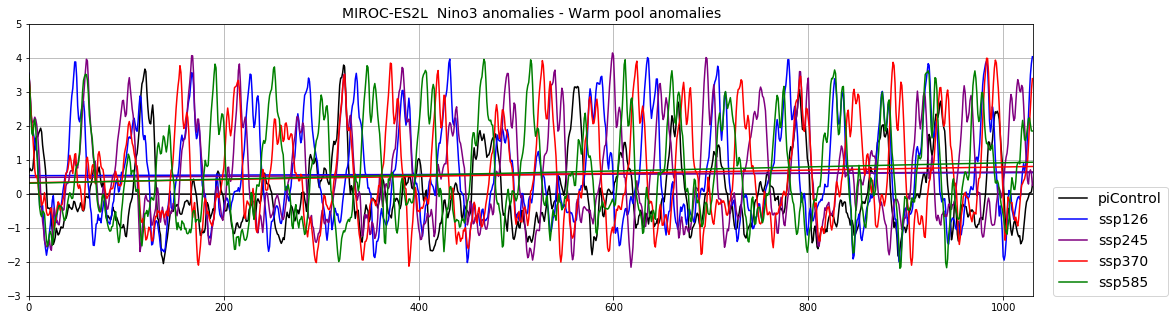

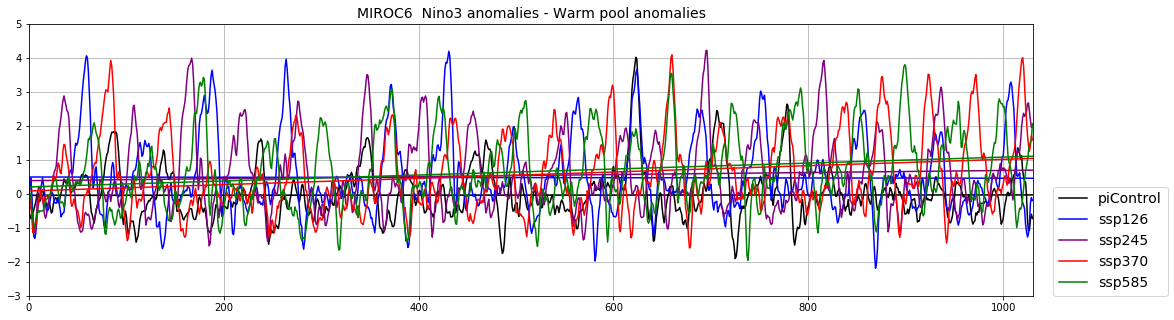

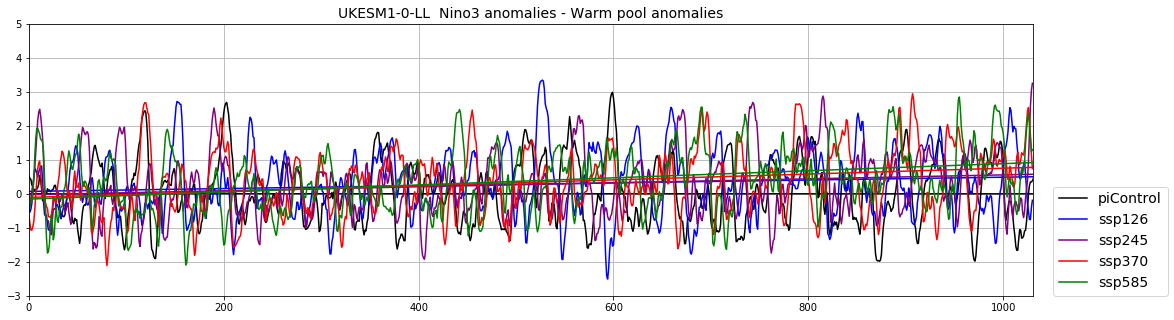

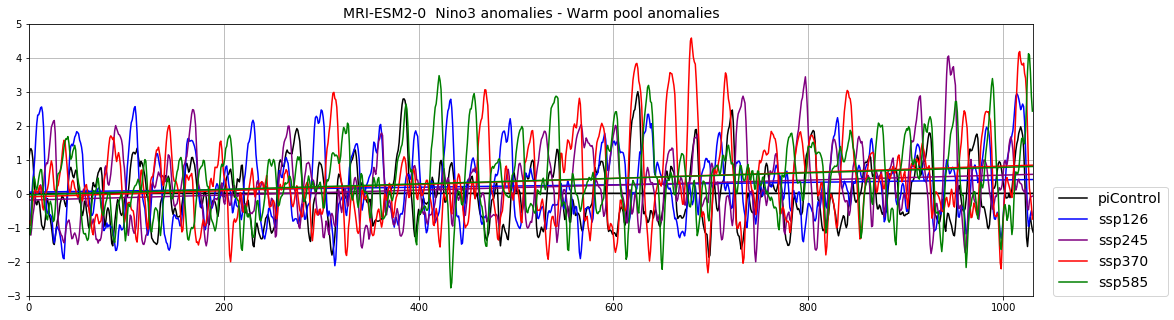

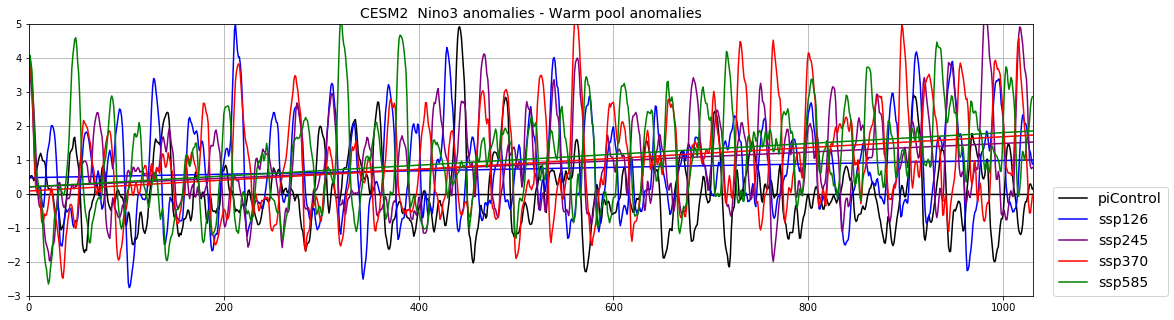

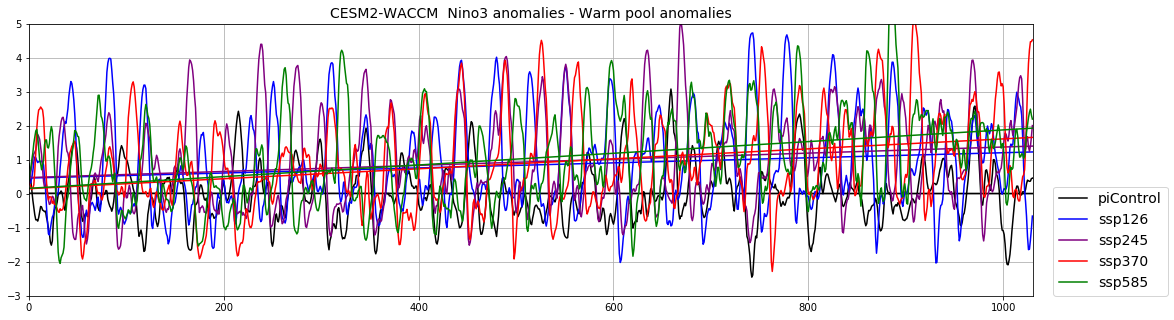

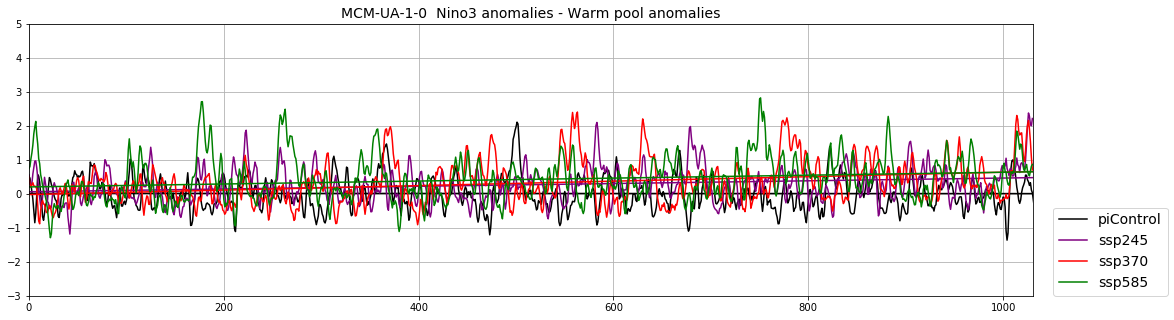

In [6]:
colors = ['black', 'blue', 'purple', 'red', 'green']
color_dict = {}
explist = ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
for ind,exp in enumerate(explist):
    color_dict[exp] = colors[ind]

for model in models:
    fig, ax = plt.subplots(figsize = [18,5])
    for exp in gradient[model]:
        y = gradient[model][exp][1979:]; t = np.arange(0,len(y))
        ax.plot(t, y, label = exp, color = color_dict[exp])
        
        # fit linear trend
        p = np.polyfit(t,y,1)
        fit = np.polyval(p,t)
        
        ax.plot(t, fit, color = color_dict[exp])
        #ax.plot([0, len(y)], [np.mean(y), np.mean(y)], color = color_dict[exp])
    ax.set_title(model + '  Nino3 anomalies - Warm pool anomalies', fontsize = 14)
    ax.set_xlim(0,len(y))
    ax.set_ylim(-3,5)
    ax.grid()
    ax.legend(loc=(1.02,0), fontsize = 14)
    